In [37]:
import numpy as np
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import umap
import math
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib.transforms as mtrans
import yaml
from yaml.loader import SafeLoader
from collections import OrderedDict
#from verstack.stratified_continuous_split import scsplit
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVC
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import seaborn as sns
import random as rd
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

In [13]:
out_dir = '/volatile/jl277509/Runs/02_STS_babies/Program/Output/'
#model = '1-5mm_STS_babies/14-06-51_2/'
model = 'STS_1-5mm_d5_t1/14-54-09_0/'
epochs = [None]

In [14]:
# load dHCP labels
preterm_labels = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/preterm_labels.csv')

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


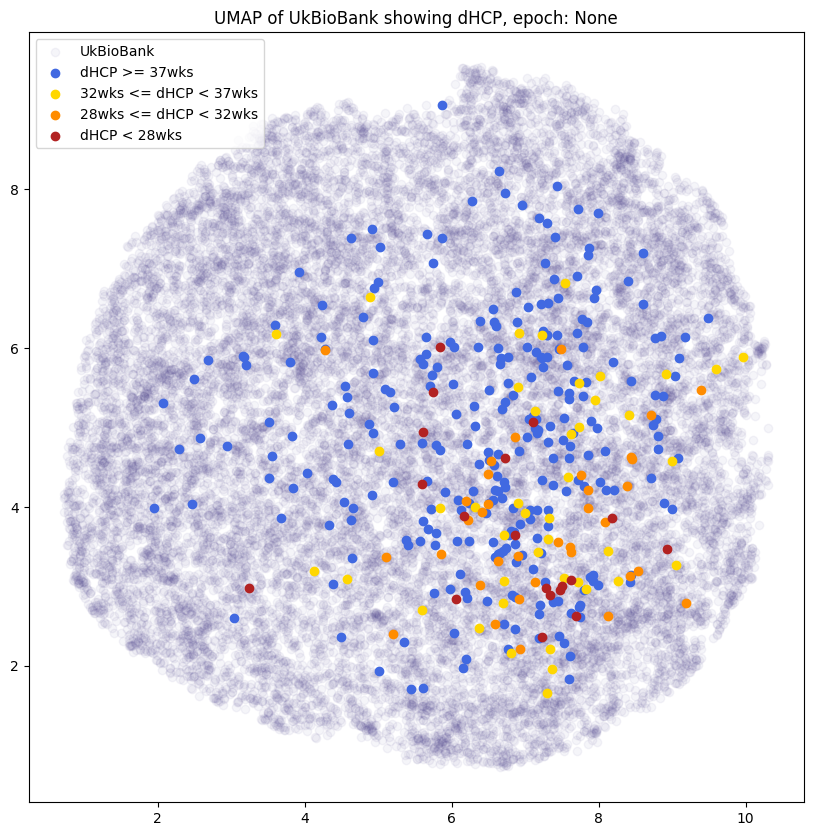

In [19]:
for epoch in epochs:
    if epoch!=None:
        ukb_embeddings = pd.read_csv(os.path.join(out_dir,model)+f'UKB_epoch{epoch}_embeddings/full_embeddings.csv')
        dHCP_embeddings = pd.read_csv(os.path.join(out_dir,model)+f'dHCP_epoch{epoch}_embeddings/full_embeddings.csv')
    else:
        ukb_embeddings = pd.read_csv(os.path.join(out_dir,model)+f'UKB_embeddings/full_embeddings.csv')
        dHCP_embeddings = pd.read_csv(os.path.join(out_dir,model)+f'dHCP_embeddings/full_embeddings.csv') 

    # fit UMAP on UKB
    reducer = umap.UMAP(random_state=1)
    dims = [f'dim{k}' for k in range(1,11)]
    X = ukb_embeddings[dims]
    embeddings_ukb = reducer.fit_transform(X)

    # label 28
    preterm_28 = preterm_labels.loc[preterm_labels['birth_age']<28]
    embeddings_28 = dHCP_embeddings.loc[dHCP_embeddings['ID'].isin(preterm_28.Subject)]
    Y = embeddings_28[dims]
    embeddings_28 = reducer.transform(Y)

    # label 32
    preterm_32 = preterm_labels.loc[(preterm_labels['birth_age']<32) & (preterm_labels['birth_age']>=28)]
    embeddings_32 = dHCP_embeddings.loc[dHCP_embeddings['ID'].isin(preterm_32.Subject)]
    Y = embeddings_32[dims]
    embeddings_32 = reducer.transform(Y)

    # label 37
    preterm_37 = preterm_labels.loc[(preterm_labels['birth_age']<37) & (preterm_labels['birth_age']>=32)]
    embeddings_37 = dHCP_embeddings.loc[dHCP_embeddings['ID'].isin(preterm_37.Subject)]
    Y = embeddings_37[dims]
    embeddings_37 = reducer.transform(Y)

    # label 37
    fullterm = preterm_labels.loc[preterm_labels['birth_age']>=37]
    embeddings_fullterm = dHCP_embeddings.loc[dHCP_embeddings['ID'].isin(fullterm.Subject)]
    Y = embeddings_fullterm[dims]
    embeddings_fullterm = reducer.transform(Y)

    fig, ax = plt.subplots(figsize=(10,10))
    plt.scatter(embeddings_ukb[:,0], embeddings_ukb[:,1], alpha=0.05, label='UkBioBank', c='darkslateblue')
    plt.scatter(embeddings_fullterm[:, 0], embeddings_fullterm[:, 1], label='dHCP >= 37wks', c='royalblue')
    plt.scatter(embeddings_37[:, 0], embeddings_37[:, 1], label='32wks <= dHCP < 37wks', c='gold')
    plt.scatter(embeddings_32[:, 0], embeddings_32[:, 1], label='28wks <= dHCP < 32wks', c='darkorange')
    plt.scatter(embeddings_28[:, 0], embeddings_28[:, 1], label='dHCP < 28wks', c='firebrick')
    plt.legend()
    plt.title(f'UMAP of UkBioBank showing dHCP, epoch: {epoch}')
    plt.show()

In [28]:
# AUC classif between dHCP and UKB ?
x_1= dHCP_embeddings[dims].to_numpy()
x_2 = ukb_embeddings[dims].to_numpy()
x = np.vstack((x_1,x_2))
scaler=StandardScaler()
x = scaler.fit_transform(x)
y = [1 for k in range(len(x_1))] + [0 for k in range(len(x_2))]

In [31]:
model = SVC(kernel='linear', probability=True,
            max_iter=-1, random_state=0,
            C=0.01, class_weight='balanced')

In [35]:
labels_proba = cross_val_predict(model, x, y, cv=3, method='predict_proba')

In [38]:
roc_auc = roc_auc_score(y, labels_proba[:, 1])
print(roc_auc)

0.9823231194262031
